# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [02:27<00:00, 2361.86it/s]


In [23]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [24]:
print(final[0:10])

            Id   ProductId          UserId                     ProfileName  \
138702  150520  0006641040   ADBFSA9KTQANE  James L. Hammock "Pucks Buddy"   
138707  150525  0006641040  A2QID6VCFTY51R                            Rick   
138708  150526  0006641040  A3E9QZFE9KXH8J                     R. Mitchell   
138692  150510  0006641040   AM1MNZMYMS7D8            Dr. Joshua  Grossman   
138689  150507  0006641040  A1S4A3IQ2MU7V4           sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X     Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                          Teresa   
138688  150506  0006641040  A2IW4PEEKO2R0U                           Tracy   
138697  150515  0006641040  A2RTT81R6Y3R7X                         Lindylu   
138709  150529  0006641040   A25ACLV5KPB4W             Matt Hetling "Matt"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138702                     0                       0      1  12566

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

In [26]:
sum=final['Summary']
print(sum.head(50))

138702                                           Great Gift
138707    In December it will be, my snowman's anniversa...
138708                               awesome book poor size
138692                               Professional Mentoring
138689                        chicken soup with rice months
138690               a good swingy rhythm for reading aloud
138691                      A great way to learn the months
138688           Love the book, miss the hard cover version
138697                   One of our family's favorite books
138709                          Nice cadence, catchy rhymes
138696                               Chicken soup with Rice
138695                                            A classic
138694                                           Must have.
138693                               Charming and childlike
138681                                    Can't explain why
138703                                  This book is great!
138680                                  

In [27]:
from tqdm import tqdm
preprocessed_summary=[]
for summary in tqdm(final['Summary'].values):
    summary=decontracted(summary)
    summary=re.sub('[^A-Za-z0-9]',' ', summary)
    summary=re.sub("\S*\d\S*", "", summary).strip()
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [02:21<00:00, 2462.66it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (348260, 113898)
the number of unique words  113898


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (348260, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (348260, 194764)
the number of unique words including both unigrams and bigrams  194764


## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8972283005714417), ('fantastic', 0.8853132724761963), ('awesome', 0.8721697330474854), ('excellent', 0.8631871938705444), ('good', 0.8589192032814026), ('wonderful', 0.8158056735992432), ('perfect', 0.7938220500946045), ('nice', 0.7617648243904114), ('fabulous', 0.738246738910675), ('amazing', 0.7365685105323792)]
[('nastiest', 0.8468483686447144), ('greatest', 0.75947105884552), ('disgusting', 0.737451434135437), ('best', 0.7314943075180054), ('terrible', 0.6820940971374512), ('horrible', 0.6791771650314331), ('vile', 0.6780681610107422), ('awful', 0.6584486961364746), ('tastiest', 0.6510522961616516), ('worse', 0.6461122035980225)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  32908
sample words  ['book', 'purchased', 'birthday', 'gift', 'year', 'old', 'boy', 'squealed', 'delight', 'hugged', 'told', 'keep', 'not', 'return', 'library', 'daughter', 'loves', 'really', 'rosie', 'books', 'introduced', 'cd', 'performed', 'carole', 'king', 'also', 'available', 'amazon', 'later', 'knows', 'songs', 'far', 'go', 'one', 'johnny', 'around', 'chicken', 'soup', 'w', 'rice', 'well', 'written', 'clever', 'art', 'work', 'maurice', 'sendak', 'plus', 'cheap', 'highly']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 348260/348260 [21:13<00:00, 273.41it/s]


348260
50


#### [4.4.1.2] TFIDF weighted W2v

In [35]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

  2%|█▏                                                                       | 5420/348260 [10:03<11:34:48,  8.22it/s]

KeyboardInterrupt: 

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation

 Objective: We need to use the preprocessed reviews and apply KNN brute force algorithm to find the whether a query point will belong to positive or negative class. 
 
 We will be considering 100K (50 K positive and 50 K negative) reviews to build our model. The skleton of the solution is as follows:
 
 1. Load the preprocessed reviews. And consider only the reviews and score columns. Use 100K datapoints.
 2. Then split the data in 60:20:20 (Train, Cross validation, Test).
 3. To avoid DATA LEAKAGE,  we should first split the preprocessed data and later do the vectorization.
 

In [37]:
final['processed_review']=preprocessed_reviews

In [38]:
print(final.head(3))
final.shape

            Id   ProductId          UserId                     ProfileName  \
138702  150520  0006641040   ADBFSA9KTQANE  James L. Hammock "Pucks Buddy"   
138707  150525  0006641040  A2QID6VCFTY51R                            Rick   
138708  150526  0006641040  A3E9QZFE9KXH8J                     R. Mitchell   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138702                     0                       0      1  1256688000   
138707                     1                       2      1  1025481600   
138708                    11                      18      0  1129507200   

                                                  Summary  \
138702                                         Great Gift   
138707  In December it will be, my snowman's anniversa...   
138708                             awesome book poor size   

                                                     Text  \
138702  This book was purchased as a birthday gift for...   
138707  My daughter

(348260, 11)

since we will be using the dataset for future model development, its prude to store the dataset as table into SQLLite.

In [39]:
table= sqlite3.connect('final.sqlite')
c=table.cursor()
final.to_sql('cleaned', table,schema=None,if_exists='replace',index=True,dtype=None)

In [40]:
connect=sqlite3.connect('final.sqlite')


In [41]:
cleaned_data= pd.read_sql_query("select * from cleaned", connect)

In [42]:
cleaned_data.shape

(348260, 12)

We will use 10K positive and negative reviews for KNN brute force

In [43]:
pos = cleaned_data[cleaned_data["Score"]==1].sample(n=50000)
neg = cleaned_data[cleaned_data["Score"]==0].sample(n=50000)
sample_100k = pd.concat([pos,neg])
sample_100k.shape

(100000, 12)

As we learnt its wise to sort the data based on time stamp as it will be helpful in training our model if we have completely new datapoints

In [44]:
sample_100k['Time'] = pd.to_datetime(sample_100k['Time'], unit = 's')
sample_100k= sample_100k.sort_values(by='Time')

In [45]:
sample_100k.head()

index      Id   ProductId          UserId       ProfileName  \
251  346041  374343  B00004CI84   A1B2IZU1JLZA6               Wes   
342  346141  374450  B00004CI84   ACJR7EQF9S6FP  Jeremy Robertson   
429  417901  451923  B00004CXX9   ANIMV3SPDD8SH  Guy De Federicis   
274  346037  374339  B00004CI84   AZRJH4JFB59VC  Lynwood E. Hines   
848  138016  149787  B00004S1C6  A2XZKD83G4N9Y5     Cindy Elliott   

     HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
251                    19                      23      0 2000-01-19   
342                     2                       3      1 2000-02-26   
429                     1                      12      0 2001-06-11   
274                    21                      23      0 2001-08-08   
848                    43                      45      1 2002-11-05   

                                             Summary  \
251  WARNING: CLAMSHELL EDITION IS EDITED TV VERSION   
342         Bettlejuice...Bettlejuice...BETTLEJUICE!   
429                CASPER IS THE GHOST WITH THE MOST   
274                        Great movie, terrible DVD   
848                                           Great!   

                                                  Text  \
251  I, myself always enjoyed this movie, it's very...   
342  What happens when you say his name three times...   
429  Michael Keaton brings no distinguishing charac...   
274  I am continually amazed at the shoddy treatmen...   
848  For those wondering, the bottles are each 3/4 ...   

                                      processed_review  
251  always enjoyed movie funny entertaining not he...  
342  happens say name three times michael keaten st...  
429  michael keaton brings no distinguishing charac...  
274  continually amazed shoddy treatment movies get...  
848  wondering bottles oz gel food color vibrant am...

Since all the preprocessing has been done, we will now split the data into train, cross validation and test set.

In [46]:
X = sample_100k['processed_review']
Y = sample_100k['Score']

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter

In [48]:
X_train,X_test,Y_train,Y_test= train_test_split(X, Y, test_size=0.4,random_state= 20)
X_test,X_cv,Y_test,Y_cv=train_test_split(X_test,Y_test,test_size=0.5,random_state= 20)
print("The Shape of train data is :",X_train.shape, Y_train.shape)
print("The Shape of CV data is :",X_cv.shape, Y_cv.shape)
print("The Shape of test data is :",X_test.shape, Y_test.shape)

The Shape of train data is : (60000,) (60000,)
The Shape of CV data is : (20000,) (20000,)
The Shape of test data is : (20000,) (20000,)


In [49]:
#We will make the model learn the vocab from train dataset. We will use countvectorizer to serve our purpose
vec= CountVectorizer()
vec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [50]:
# Now we will apply the learned vocab to train,test,CV datawhich will produce an output in BOW format
bow_train=vec.transform(X_train)
bow_cv=vec.transform(X_cv)
bow_test=vec.transform(X_test)

In [51]:
print("After Vectorization")
print(bow_train.shape,Y_train.shape)
print(bow_cv.shape,Y_cv.shape)
print(bow_test.shape,Y_test.shape)

After Vectorization
(60000, 48291) (60000,)
(20000, 48291) (20000,)
(20000, 48291) (20000,)


Finding Best K value using Timesplit CV

#Now we will use the gridsearch cross validation to find the optimum K value and fit our model using the value.

In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
knn = KNeighborsClassifier()
#we will create a dictonary of values using which we will test for n_neighbors
para_grid= {'n_neighbors':np.arange(1,57)}
#We will use the gridsearch to test all aforementioned values for n_neighbors
knn_gscv= GridSearchCV(knn,para_grid,cv=3,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_bow data
knn_gscv.fit(bow_train,Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [54]:
#The best K value obtained from the gridsearchCV is 
best_k= knn_gscv.best_params_
print("Best K Hyperparameter:", best_k)
print("The accuracy obtained by using the K value is:", knn_gscv.best_score_*100)
k_best=12

Best K Hyperparameter: {'n_neighbors': 56}
The accuracy obtained by using the K value is: 69.85813446099205


[0.99878328 0.93320297 0.91283655 0.86624086 0.84936636 0.83625021
 0.82537702 0.81653028 0.80969231 0.80327677 0.79770055 0.7931988
 0.789151   0.78531223 0.78191563 0.77894303 0.77637673 0.77359124
 0.77161657 0.7696795  0.7674356  0.76519732 0.76374586 0.76223347
 0.76059572 0.75929004 0.7583159  0.75706779 0.75607948 0.7552505
 0.75427158 0.75340186 0.75252386 0.75165075 0.75091079 0.75003261
 0.74931295 0.74897953 0.74866619 0.74788364 0.74723611 0.74685426
 0.74645335 0.74620277 0.7459982  0.7456105  0.74513973 0.74501401
 0.74453565 0.74427704 0.74429564 0.74415295 0.74412537 0.74382087
 0.74388378 0.74356328]


Text(0.5, 1.0, 'Error Plot')

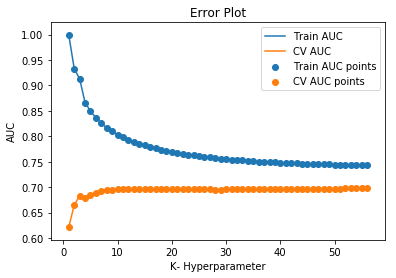

In [56]:
train_auc=knn_gscv.cv_results_['mean_train_score']
cv_auc=knn_gscv.cv_results_['mean_test_score']
print(train_auc)
plt.plot(np.arange(1,57,1),train_auc,label='Train AUC')
plt.plot(np.arange(1,57,1),cv_auc,label='CV AUC')
plt.scatter(np.arange(1,57,1),train_auc,label='Train AUC points')
plt.scatter(np.arange(1,57,1),cv_auc,label='CV AUC points')
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')


From the above error plot we should choose the K Value such that the area under curve should be maximum. We will select K=12 which is the best K provided by the gridsearchCV

We will be using the best K value and we will test the model accuracy on our cross validation and test data.

In [57]:
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(bow_train, Y_train)
y_train_pred= knn.predict(bow_train)
y_test_pred=knn.predict(bow_test)
y_cv_pred= knn.predict(bow_cv)



In [58]:
train_fpr,train_tpr,thersholds=roc_curve(Y_train,y_train_pred)
cv_fpr,cv_tpr,thersholds=roc_curve(Y_cv,y_cv_pred)
test_fpr,test_tpr,thersholds=roc_curve(Y_test,y_test_pred)

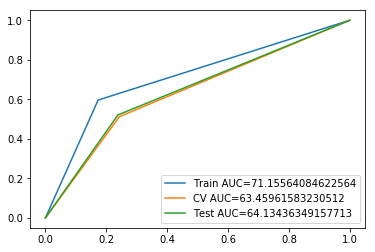

In [221]:
plt.plot(train_fpr,train_tpr,label="Train AUC=" +str(auc(train_fpr,train_tpr)*100))
plt.plot(cv_fpr,cv_tpr,label="CV AUC=" +str(auc(cv_fpr,cv_tpr)*100))
plt.plot(test_fpr,test_tpr,label="Test AUC=" +str(auc(test_fpr,test_tpr)*100))
plt.legend()

In [60]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Y_train,y_train_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Y_cv,y_cv_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Y_test,y_test_pred)*100))

Accuracy on Train dataset: 71.15%
Accuracy on CV dataset: 63.39%
Accuracy on Test dataset: 64.22%


In [61]:
import seaborn as sns
from sklearn.metrics import classification_report

Text(33.0, 0.5, 'True Label')

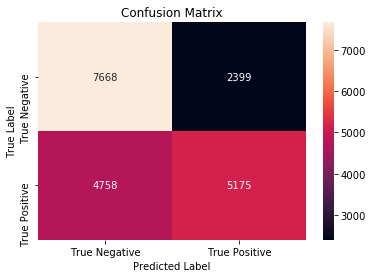

In [62]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,y_test_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [63]:
print(classification_report(Y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68     10067
           1       0.68      0.52      0.59      9933

   micro avg       0.64      0.64      0.64     20000
   macro avg       0.65      0.64      0.64     20000
weighted avg       0.65      0.64      0.64     20000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 5175
    True Negative  : 7668
    False Positive : 2399 [Also know as type one error]
    False Negative : 4758 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (5175+7668)/20000 = 64.2 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 12)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (2399+4758)/20000 = 35.7 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 12)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 5175/ (5175+2399) = 68.32%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 7668/ (7668+4758) = 61.70%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 5175/ (5175+4758) = 52.09%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 7668/ (7668+2399) = 76.16%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.59
                    For -ve class = 0.68
OBSERVATION:
1. The model provides 64% accuracy on test data wheras it provides 71% accuracy on train data valid when K = 12.
2. From the confusion matrix, it can be deduced that out of 20K datapoints our KNN classfier predicts 7574 +ve and 12426 -ve class label but in reality 9933 +ve and 10067 -ve class labels.
3. We can conclude that model doesnot work good on unseen data due to generalization error.

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

In [86]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # we are using bi grams
tf_train=tf_idf_vect.fit_transform(X_train)
tf_test=tf_idf_vect.transform(X_test)
tf_cv=tf_idf_vect.transform(X_cv)

In [87]:
print("After Vectorization")
print(tf_train.shape,Y_train.shape)
print(tf_cv.shape,Y_cv.shape)
print(tf_test.shape,Y_test.shape)

After Vectorization
(60000, 1123213) (60000,)
(20000, 1123213) (20000,)
(20000, 1123213) (20000,)


In [88]:
knn = KNeighborsClassifier()
#we will create a dictonary of values using which we will test for n_neighbors
para_grid1= {'n_neighbors':np.arange(1,57)}
#We will use the gridsearch to test all aforementioned values for n_neighbors
knn_gscvtf= GridSearchCV(knn,para_grid1,cv=3,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_bow data
knn_gscvtf.fit(tf_train,Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [91]:
#The best K value obtained from the gridsearchCV is 
best_k= knn_gscvtf.best_params_
print("Best K Hyperparameter:", best_k)
print("The accuracy obtained by using the K value is:", knn_gscvtf.best_score_*100)
k_best_tf=4

Best K Hyperparameter: {'n_neighbors': 3}
The accuracy obtained by using the K value is: 50.54004435493511


[0.99878328 0.99876005 0.99881911 0.77966249 0.75269381 0.73374116
 0.71867621 0.70722986 0.69761148 0.6888395  0.68101823 0.67438049
 0.66853892 0.66315162 0.6578517  0.65318118 0.64950599 0.64671964
 0.64405499 0.64168314 0.63912872 0.63761994 0.63518639 0.63332789
 0.63271473 0.6312262  0.62952558 0.62726952 0.62652368 0.62587047
 0.62423567 0.62311485 0.62185402 0.62077578 0.61975685 0.61977748
 0.61968281 0.61965617 0.61946262 0.61892411 0.61814707 0.6179373
 0.61748762 0.61692228 0.61692498 0.61712789 0.616864   0.6174425
 0.61767856 0.61815559 0.61844448 0.61845375 0.61830604 0.61856036
 0.61885396 0.61932957]


Text(0.5, 1.0, 'Error Plot')

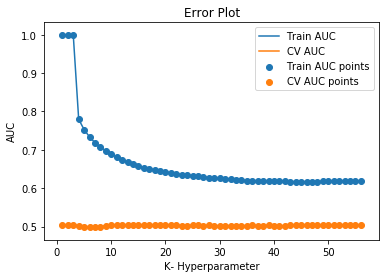

In [92]:
traintf_auc=knn_gscvtf.cv_results_['mean_train_score']
cvtf_auc=knn_gscvtf.cv_results_['mean_test_score']
print(traintf_auc)
#print(k)
plt.plot(np.arange(1,57,1),traintf_auc,label='Train AUC')
plt.plot(np.arange(1,57,1),cvtf_auc,label='CV AUC')
plt.scatter(np.arange(1,57,1),traintf_auc,label='Train AUC points')
plt.scatter(np.arange(1,57,1),cvtf_auc,label='CV AUC points')
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')


In [93]:
knn = KNeighborsClassifier(n_neighbors=k_best_tf)
knn.fit(tf_train, Y_train)
y_traintf_pred= knn.predict(tf_train)
y_testtf_pred=knn.predict(tf_test)
y_cvtf_pred= knn.predict(tf_cv)

In [94]:
traintf_fpr,traintf_tpr,thersholds=roc_curve(Y_train,y_traintf_pred)
cvtf_fpr,cvtf_tpr,thersholds=roc_curve(Y_cv,y_cvtf_pred)
testtf_fpr,testtf_tpr,thersholds=roc_curve(Y_test,y_testtf_pred)

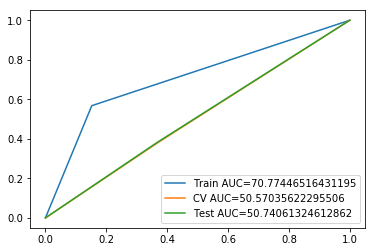

In [95]:
plt.plot(traintf_fpr,traintf_tpr,label="Train AUC=" +str(auc(traintf_fpr,traintf_tpr)*100))
plt.plot(cvtf_fpr,cvtf_tpr,label="CV AUC=" +str(auc(cvtf_fpr,cvtf_tpr)*100))
plt.plot(testtf_fpr,testtf_tpr,label="Test AUC=" +str(auc(testtf_fpr,testtf_tpr)*100))
plt.legend()

In [96]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Y_train,y_traintf_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Y_cv,y_cvtf_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Y_test,y_testtf_pred)*100))

Accuracy on Train dataset: 70.77%
Accuracy on CV dataset: 50.50%
Accuracy on Test dataset: 50.82%


Text(33.0, 0.5, 'True Label')

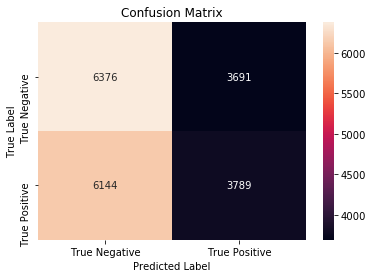

In [97]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,y_testtf_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 3789
    True Negative  : 6376
    False Positive : 3691 [Also know as type one error]
    False Negative : 6144 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (3789+6376)/20000 = 50.82 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 4)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (3691+6144)/20000 = 49.17 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 4)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 3789/ (3789+3691) = 50.65%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 6376/ (6376+6144) = 50.92%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 3789/ (3789+6144) = 38.14%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 6376/ (6376+3691) = 63.33%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.43
                    For -ve class = 0.56
OBSERVATION:
1. The model provides 50.82% accuracy on test data wheras it provides 70.7% accuracy on train data valid when K = 4.
2. From the confusion matrix, it can be deduced that out of 20K datapoints our KNN classfier predicts  7480 +ve and 12520 -ve class label but in reality 9933 +ve and 10067 -ve class labels.
3. We can conclude that model doesnot work good on unseen data due to generalization error.

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [98]:
# Please write all the code with proper documentation

In [99]:
# Train your own Word2Vec model using your own text corpus
i=0
sentance_train=[]
for sentance in X_train:
    sentance_train.append(sentance.split())

In [100]:
# to train the W2V model on the provided list of sentences
w2v_model=Word2Vec(sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15356
sample words  ['gave', 'old', 'cat', 'month', 'day', 'came', 'kidney', 'disease', 'died', 'soon', 'slow', 'painful', 'death', 'told', 'could', 'caused', 'greenies', 'please', 'not', 'give', 'pet', 'product', 'risky', 'link', 'complaints', 'receive', 'one', 'box', 'taco', 'shells', 'count', 'believe', 'list', 'price', 'great', 'sale', 'much', 'shipment', 'weighs', 'wrong', 'end', 'paying', 'ad', 'removed', 'soooo', 'miss', 'leading', 'would', 'pay', 'pounds']


In [101]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_train.append(sent_vec)
print(len(vectors_train))
print(len(vectors_train[0]))


  5%|████                                                                        | 3167/60000 [00:07<02:01, 469.36it/s]


 10%|███████▋                                                                    | 6020/60000 [00:14<02:12, 406.25it/s]


 15%|███████████▋                                                                | 9215/60000 [00:22<02:31, 334.64it/s]


 21%|███████████████▋                                                           | 12502/60000 [00:30<02:25, 326.97it/s]


 25%|███████████████████                                                        | 15284/60000 [00:38<02:41, 277.23it/s]


 29%|█████████████████████▊                                                     | 17457/60000 [00:45<02:22, 299.29it/s]


 33%|█████████████████████████                                                  | 20073/60000 [00:53<01:47, 372.74it/s]


 37%|████████████████████████████                                               | 22438/60000 [01:01<01:52, 333.98it/s]


 42%|███████████████████████████████▎                                           | 25060/60000 [01:09<02:09, 270.79it/s]


 46%|██████████████████████████████████▋                                        | 27785/60000 [01:17<01:48, 297.53it/s]


 50%|█████████████████████████████████████▍                                     | 29978/60000 [01:25<02:04, 240.76it/s]


 53%|████████████████████████████████████████                                   | 32099/60000 [01:32<01:31, 305.88it/s]


 57%|██████████████████████████████████████████▉                                | 34396/60000 [01:40<01:26, 297.18it/s]


 61%|█████████████████████████████████████████████▉                             | 36791/60000 [01:48<01:12, 319.39it/s]


 65%|████████████████████████████████████████████████▊                          | 39029/60000 [01:56<01:22, 253.75it/s]


 69%|███████████████████████████████████████████████████▋                       | 41301/60000 [02:04<00:56, 330.30it/s]


 73%|██████████████████████████████████████████████████████▌                    | 43629/60000 [02:12<00:54, 300.88it/s]


 76%|█████████████████████████████████████████████████████████▎                 | 45846/60000 [02:19<00:53, 262.98it/s]


 80%|████████████████████████████████████████████████████████████▎              | 48264/60000 [02:27<00:35, 332.87it/s]


 84%|███████████████████████████████████████████████████████████████▏           | 50590/60000 [02:35<00:29, 323.22it/s]


 88%|██████████████████████████████████████████████████████████████████▎        | 53085/60000 [02:43<00:24, 279.14it/s]


 92%|█████████████████████████████████████████████████████████████████████▏     | 55381/60000 [02:50<00:12, 376.76it/s]


 97%|████████████████████████████████████████████████████████████████████████▌  | 58040/60000 [02:58<00:04, 434.30it/s]


100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:03<00:00, 326.37it/s]

60000
50


In [102]:
# Converting the CV data text
i=0
sentance_cv=[]
for sentance in X_cv:
    sentance_cv.append(sentance.split())

In [103]:
# we will convert the CV data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_cv.append(sent_vec)
print(len(vectors_cv))
print(len(vectors_cv[0]))


 12%|████████▊                                                                   | 2322/20000 [00:07<00:50, 348.82it/s]


 23%|█████████████████▍                                                          | 4604/20000 [00:15<00:56, 273.31it/s]


 33%|█████████████████████████▍                                                  | 6699/20000 [00:23<00:51, 256.63it/s]


 44%|█████████████████████████████████▋                                          | 8858/20000 [00:31<00:40, 278.43it/s]


 55%|█████████████████████████████████████████▍                                 | 11066/20000 [00:39<00:31, 285.04it/s]


 66%|█████████████████████████████████████████████████▊                         | 13281/20000 [00:47<00:26, 258.20it/s]


 78%|██████████████████████████████████████████████████████████▏                | 15508/20000 [00:55<00:19, 226.87it/s]


 90%|███████████████████████████████████████████████████████████████████▏       | 17901/20000 [01:03<00:07, 281.62it/s]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:10<00:00, 285.57it/s]

20000
50


In [104]:
# Converting the test data text
i=0
sentance_test=[]
for sentance in X_test:
    sentance_test.append(sentance.split())

In [105]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_test.append(sent_vec)
print(len(vectors_test))
print(len(vectors_test[0]))


 13%|█████████▊                                                                  | 2580/20000 [00:07<00:54, 322.32it/s]


 23%|█████████████████▍                                                          | 4575/20000 [00:15<00:46, 332.71it/s]


 36%|███████████████████████████▏                                                | 7145/20000 [00:23<00:38, 332.87it/s]


 49%|█████████████████████████████████████▎                                      | 9819/20000 [00:30<00:25, 404.10it/s]


 60%|████████████████████████████████████████████▊                              | 11934/20000 [00:38<00:24, 323.59it/s]


 71%|█████████████████████████████████████████████████████▏                     | 14172/20000 [00:46<00:22, 261.33it/s]


 82%|█████████████████████████████████████████████████████████████▋             | 16453/20000 [00:54<00:13, 267.66it/s]


 93%|█████████████████████████████████████████████████████████████████████▋     | 18592/20000 [01:02<00:04, 296.41it/s]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:07<00:00, 296.70it/s]

20000
50


In [106]:
knn = KNeighborsClassifier()
#we will create a dictonary of values using which we will test for n_neighbors
para_grid2= {'n_neighbors':np.arange(1,57)}
#We will use the gridsearch to test all aforementioned values for n_neighbors
knn_gscvw2v= GridSearchCV(knn,para_grid2,cv=3,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_w2v data
knn_gscvw2v.fit(vectors_train,Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [107]:
#The best K value obtained from the gridsearchCV is 
best_k= knn_gscvw2v.best_params_
print("Best K Hyperparameter:", best_k)
print("The accuracy obtained by using the K value is:", knn_gscvw2v.best_score_*100)
k_best_w2v=5

Best K Hyperparameter: {'n_neighbors': 56}
The accuracy obtained by using the K value is: 90.62268412490737


[0.99890812 0.96815768 0.95508209 0.94745208 0.94248494 0.93860081
 0.93634654 0.9338883  0.93215414 0.93081104 0.92949282 0.92825111
 0.92740228 0.92654187 0.92573262 0.92488763 0.92434053 0.92378148
 0.92324177 0.92266909 0.92232113 0.92184273 0.92142691 0.92108847
 0.92071642 0.92039972 0.92011513 0.91990492 0.9196392  0.91947011
 0.91922873 0.91898499 0.9187775  0.918599   0.91847288 0.91837872
 0.91814765 0.91796885 0.91774523 0.91755674 0.91732395 0.9171885
 0.91699754 0.91685931 0.91671472 0.91657703 0.91640466 0.91622262
 0.91607306 0.91598933 0.91585509 0.91573067 0.91568405 0.91560657
 0.91547064 0.91538568]


Text(0.5, 1.0, 'Error Plot')

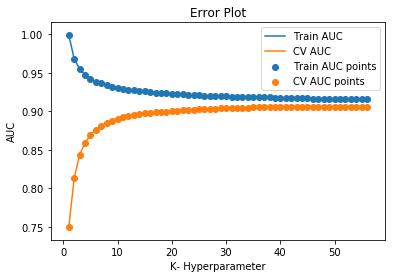

In [108]:
trainw2v_auc=knn_gscvw2v.cv_results_['mean_train_score']
cvw2v_auc=knn_gscvw2v.cv_results_['mean_test_score']
print(trainw2v_auc)
#print(k)
plt.plot(np.arange(1,57,1),trainw2v_auc,label='Train AUC')
plt.plot(np.arange(1,57,1),cvw2v_auc,label='CV AUC')
plt.scatter(np.arange(1,57,1),trainw2v_auc,label='Train AUC points')
plt.scatter(np.arange(1,57,1),cvw2v_auc,label='CV AUC points')
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')


In [109]:
knn = KNeighborsClassifier(n_neighbors=k_best_w2v)
knn.fit(vectors_train, Y_train)
y_trainw2v_pred= knn.predict(vectors_train)
y_testw2v_pred=knn.predict(vectors_test)
y_cvw2v_pred= knn.predict(vectors_cv)

In [110]:
trainw2v_fpr,trainw2v_tpr,thersholds=roc_curve(Y_train,y_trainw2v_pred)
cvw2v_fpr,cvw2v_tpr,thersholds=roc_curve(Y_cv,y_cvw2v_pred)
testw2v_fpr,testw2v_tpr,thersholds=roc_curve(Y_test,y_testw2v_pred)

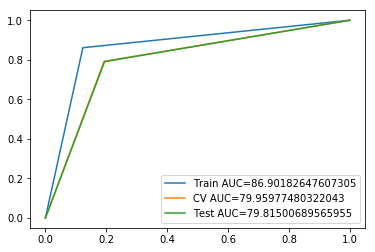

In [111]:
plt.plot(trainw2v_fpr,trainw2v_tpr,label="Train AUC=" +str(auc(trainw2v_fpr,trainw2v_tpr)*100))
plt.plot(cvw2v_fpr,cvw2v_tpr,label="CV AUC=" +str(auc(cvw2v_fpr,cvw2v_tpr)*100))
plt.plot(testw2v_fpr,testw2v_tpr,label="Test AUC=" +str(auc(testw2v_fpr,testw2v_tpr)*100))
plt.legend()

In [112]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Y_train,y_trainw2v_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Y_cv,y_cvw2v_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Y_test,y_testw2v_pred)*100))

Accuracy on Train dataset: 86.90%
Accuracy on CV dataset: 79.95%
Accuracy on Test dataset: 79.82%


Text(33.0, 0.5, 'True Label')

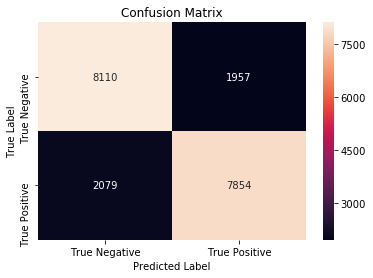

In [113]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,y_testw2v_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [211]:
print(classification_report(Y_test,y_testw2v_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     10067
           1       0.80      0.79      0.80      9933

   micro avg       0.80      0.80      0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 7854
    True Negative  : 8110
    False Positive : 1957 [Also know as type one error]
    False Negative : 2079 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (7854+8110)/20000 = 79.82 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 5)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (1957+2079)/20000 = 20.18 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 5)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 7854/ (7854+1957) = 80.05%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 8110/ (8110+2079) = 79.59%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 7854/ (7854+2079) = 79.06%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 8110/ (8110+1957) = 80.56%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.80
                    For -ve class = 0.80
OBSERVATION:
1. The model provides 86% accuracy on test data wheras it provides 80% accuracy on train data valid when K = 5.
2. From the confusion matrix, it can be deduced that out of 20K datapoints our KNN classfier predicts  9811 +ve and 10189 -ve class label but in reality 9933 +ve and 10067 -ve class labels.
3. We can conclude that model work good on unseen data as the accuracy is high provided K=5.

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [114]:
# Please write all the code with proper documentation

In [115]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [116]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


  1%|▍                                                                             | 318/60000 [00:08<19:33, 50.85it/s]


  1%|▉                                                                             | 713/60000 [00:18<24:33, 40.23it/s]


  2%|█▍                                                                           | 1081/60000 [00:27<24:23, 40.27it/s]


  2%|█▊                                                                           | 1456/60000 [00:37<30:12, 32.30it/s]


  3%|██▍                                                                          | 1858/60000 [00:47<31:15, 31.01it/s]


  4%|██▉                                                                          | 2276/60000 [00:56<22:20, 43.08it/s]


  4%|███▍                                                                         | 2636/60000 [01:05<24:38, 38.80it/s]


  5%|███▉                                                                         | 3041/60000 [01:14<18:03, 52.56it/s]


  6%|████▍                                                                        | 3445/60000 [01:24<26:50, 35.11it/s]


  6%|████▉                                                                        | 3813/60000 [01:33<30:50, 30.36it/s]


  7%|█████▍                                                                       | 4210/60000 [01:42<21:53, 42.49it/s]


  8%|█████▉                                                                       | 4578/60000 [01:51<23:13, 39.77it/s]


  8%|██████▎                                                                      | 4967/60000 [02:01<17:41, 51.84it/s]


  9%|██████▉                                                                      | 5361/60000 [02:10<24:20, 37.41it/s]


 10%|███████▎                                                                     | 5735/60000 [02:20<31:00, 29.17it/s]


 10%|███████▊                                                                     | 6087/60000 [02:30<32:35, 27.56it/s]


 11%|████████▎                                                                    | 6452/60000 [02:40<28:32, 31.27it/s]


 11%|████████▊                                                                    | 6849/60000 [02:49<17:25, 50.83it/s]


 12%|█████████▎                                                                   | 7252/60000 [02:59<24:02, 36.56it/s]


 13%|█████████▊                                                                   | 7647/60000 [03:08<32:05, 27.18it/s]


 13%|██████████▎                                                                  | 8030/60000 [03:17<32:58, 26.26it/s]


 14%|██████████▊                                                                  | 8398/60000 [03:26<20:51, 41.25it/s]


 15%|███████████▏                                                                 | 8765/60000 [03:36<32:23, 26.37it/s]


 15%|███████████▋                                                                 | 9152/60000 [03:46<18:54, 44.81it/s]


 16%|████████████▏                                                                | 9518/60000 [03:55<22:04, 38.12it/s]


 17%|████████████▋                                                                | 9918/60000 [04:04<22:21, 37.34it/s]


 17%|█████████████                                                               | 10268/60000 [04:13<24:30, 33.81it/s]


 18%|█████████████▍                                                              | 10614/60000 [04:23<42:17, 19.46it/s]


 18%|█████████████▉                                                              | 10986/60000 [04:32<22:56, 35.60it/s]


 19%|██████████████▍                                                             | 11350/60000 [04:42<41:35, 19.50it/s]


 20%|██████████████▉                                                             | 11748/60000 [04:51<21:01, 38.24it/s]


 20%|███████████████▎                                                            | 12133/60000 [05:01<17:35, 45.35it/s]


 21%|███████████████▊                                                            | 12519/60000 [05:10<17:47, 44.50it/s]


 21%|████████████████▎                                                           | 12889/60000 [05:20<18:06, 43.36it/s]


 22%|████████████████▊                                                           | 13268/60000 [05:29<27:00, 28.83it/s]


 23%|█████████████████▎                                                          | 13649/60000 [05:39<17:04, 45.25it/s]


 23%|█████████████████▊                                                          | 14031/60000 [05:48<17:00, 45.06it/s]


 24%|██████████████████▏                                                         | 14386/60000 [05:58<16:41, 45.54it/s]


 25%|██████████████████▋                                                         | 14716/60000 [06:08<20:43, 36.40it/s]


 25%|███████████████████                                                         | 15090/60000 [06:17<20:51, 35.90it/s]


 26%|███████████████████▌                                                        | 15421/60000 [06:27<16:24, 45.29it/s]


 26%|███████████████████▉                                                        | 15785/60000 [06:36<18:22, 40.12it/s]


 27%|████████████████████▍                                                       | 16141/60000 [06:46<33:06, 22.07it/s]


 28%|████████████████████▉                                                       | 16505/60000 [06:55<25:27, 28.47it/s]


 28%|█████████████████████▍                                                      | 16884/60000 [07:05<28:26, 25.27it/s]


 29%|█████████████████████▊                                                      | 17223/60000 [07:15<19:16, 36.98it/s]


 29%|██████████████████████▎                                                     | 17582/60000 [07:24<22:45, 31.06it/s]


 30%|██████████████████████▋                                                     | 17960/60000 [07:34<20:12, 34.68it/s]


 31%|███████████████████████▏                                                    | 18350/60000 [07:43<17:19, 40.07it/s]


 31%|███████████████████████▋                                                    | 18741/60000 [07:52<14:27, 47.55it/s]


 32%|████████████████████████▏                                                   | 19110/60000 [08:02<25:23, 26.84it/s]


 32%|████████████████████████▋                                                   | 19500/60000 [08:12<20:49, 32.41it/s]


 33%|█████████████████████████                                                   | 19826/60000 [08:21<15:48, 42.34it/s]


 34%|█████████████████████████▌                                                  | 20189/60000 [08:31<16:47, 39.50it/s]


 34%|██████████████████████████                                                  | 20537/60000 [08:40<18:42, 35.16it/s]


 35%|██████████████████████████▍                                                 | 20881/60000 [08:50<15:05, 43.21it/s]


 35%|██████████████████████████▉                                                 | 21264/60000 [08:59<19:08, 33.72it/s]


 36%|███████████████████████████▍                                                | 21622/60000 [09:08<15:07, 42.30it/s]


 37%|███████████████████████████▊                                                | 21976/60000 [09:18<14:48, 42.80it/s]


 37%|████████████████████████████▎                                               | 22360/60000 [09:28<16:43, 37.50it/s]


 38%|████████████████████████████▊                                               | 22732/60000 [09:37<14:21, 43.28it/s]


 39%|█████████████████████████████▎                                              | 23103/60000 [09:47<14:03, 43.75it/s]


 39%|█████████████████████████████▋                                              | 23456/60000 [09:56<20:03, 30.36it/s]


 40%|██████████████████████████████▏                                             | 23813/60000 [10:06<14:38, 41.17it/s]


 40%|██████████████████████████████▋                                             | 24203/60000 [10:15<13:43, 43.46it/s]


 41%|███████████████████████████████                                             | 24539/60000 [10:25<21:07, 27.97it/s]


 41%|███████████████████████████████▍                                            | 24824/60000 [10:36<16:09, 36.29it/s]


 42%|███████████████████████████████▉                                            | 25172/60000 [10:45<17:02, 34.07it/s]


 43%|████████████████████████████████▎                                           | 25544/60000 [10:55<13:57, 41.13it/s]


 43%|████████████████████████████████▊                                           | 25921/60000 [11:04<13:25, 42.29it/s]


 44%|█████████████████████████████████▎                                          | 26291/60000 [11:13<22:55, 24.50it/s]


 44%|█████████████████████████████████▋                                          | 26635/60000 [11:23<14:04, 39.52it/s]


 45%|██████████████████████████████████▏                                         | 26976/60000 [11:33<19:27, 28.28it/s]


 46%|██████████████████████████████████▌                                         | 27307/60000 [11:42<13:58, 38.99it/s]


 46%|███████████████████████████████████                                         | 27675/60000 [11:52<14:37, 36.83it/s]


 47%|███████████████████████████████████▌                                        | 28048/60000 [12:02<14:45, 36.09it/s]


 47%|███████████████████████████████████▉                                        | 28402/60000 [12:11<20:00, 26.32it/s]


 48%|████████████████████████████████████▍                                       | 28740/60000 [12:21<13:53, 37.48it/s]


 49%|████████████████████████████████████▉                                       | 29116/60000 [12:31<16:26, 31.30it/s]


 49%|█████████████████████████████████████▎                                      | 29424/60000 [12:41<17:04, 29.84it/s]


 50%|█████████████████████████████████████▋                                      | 29763/60000 [12:50<11:53, 42.35it/s]


 50%|██████████████████████████████████████▏                                     | 30123/60000 [13:00<13:36, 36.61it/s]


 51%|██████████████████████████████████████▋                                     | 30508/60000 [13:09<10:43, 45.82it/s]


 51%|███████████████████████████████████████                                     | 30854/60000 [13:19<19:15, 25.21it/s]


 52%|███████████████████████████████████████▌                                    | 31188/60000 [13:29<11:54, 40.31it/s]


 53%|███████████████████████████████████████▉                                    | 31534/60000 [13:39<15:34, 30.45it/s]


 53%|████████████████████████████████████████▍                                   | 31885/60000 [13:48<15:49, 29.60it/s]


 54%|████████████████████████████████████████▉                                   | 32275/60000 [13:58<14:41, 31.45it/s]


 54%|█████████████████████████████████████████▎                                  | 32630/60000 [14:07<10:45, 42.42it/s]


 55%|█████████████████████████████████████████▊                                  | 32996/60000 [14:17<10:23, 43.30it/s]


 56%|██████████████████████████████████████████▏                                 | 33330/60000 [14:27<10:42, 41.49it/s]


 56%|██████████████████████████████████████████▋                                 | 33702/60000 [14:36<09:35, 45.73it/s]


 57%|███████████████████████████████████████████▏                                | 34118/60000 [14:46<11:03, 38.98it/s]


 57%|███████████████████████████████████████████▋                                | 34475/60000 [14:56<13:04, 32.53it/s]


 58%|████████████████████████████████████████████                                | 34827/60000 [15:05<15:02, 27.89it/s]


 59%|████████████████████████████████████████████▌                               | 35215/60000 [15:15<14:59, 27.54it/s]


 59%|█████████████████████████████████████████████                               | 35562/60000 [15:24<08:21, 48.76it/s]


 60%|█████████████████████████████████████████████▌                              | 35957/60000 [15:33<08:29, 47.20it/s]


 61%|██████████████████████████████████████████████                              | 36319/60000 [15:43<08:28, 46.60it/s]


 61%|██████████████████████████████████████████████▍                             | 36686/60000 [15:52<12:49, 30.31it/s]


 62%|██████████████████████████████████████████████▉                             | 37051/60000 [16:02<08:19, 45.90it/s]


 62%|███████████████████████████████████████████████▍                            | 37425/60000 [16:12<07:06, 52.91it/s]


 63%|███████████████████████████████████████████████▉                            | 37802/60000 [16:21<07:10, 51.58it/s]


 64%|████████████████████████████████████████████████▍                           | 38193/60000 [16:30<08:36, 42.24it/s]


 64%|████████████████████████████████████████████████▋                           | 38484/60000 [16:41<16:12, 22.13it/s]


 65%|█████████████████████████████████████████████████▏                          | 38806/60000 [16:50<06:48, 51.83it/s]


 65%|█████████████████████████████████████████████████▌                          | 39172/60000 [16:59<12:34, 27.60it/s]


 66%|██████████████████████████████████████████████████                          | 39513/60000 [17:09<12:49, 26.62it/s]


 66%|██████████████████████████████████████████████████▍                         | 39851/60000 [17:18<08:58, 37.44it/s]


 67%|██████████████████████████████████████████████████▉                         | 40201/60000 [17:28<11:12, 29.42it/s]


 68%|███████████████████████████████████████████████████▍                        | 40592/60000 [17:37<07:30, 43.04it/s]


 68%|███████████████████████████████████████████████████▊                        | 40919/60000 [17:47<08:45, 36.33it/s]


 69%|████████████████████████████████████████████████████▎                       | 41287/60000 [17:56<06:20, 49.15it/s]


 69%|████████████████████████████████████████████████████▊                       | 41674/60000 [18:06<06:06, 50.04it/s]


 70%|█████████████████████████████████████████████████████▎                      | 42067/60000 [18:15<08:57, 33.34it/s]


 71%|█████████████████████████████████████████████████████▋                      | 42424/60000 [18:25<07:38, 38.37it/s]


 71%|██████████████████████████████████████████████████████▏                     | 42788/60000 [18:34<07:01, 40.85it/s]


 72%|██████████████████████████████████████████████████████▋                     | 43148/60000 [18:44<05:58, 47.03it/s]


 72%|███████████████████████████████████████████████████████                     | 43473/60000 [18:54<05:28, 50.25it/s]


 73%|███████████████████████████████████████████████████████▍                    | 43800/60000 [19:04<10:01, 26.92it/s]


 73%|███████████████████████████████████████████████████████▊                    | 44069/60000 [19:13<09:26, 28.10it/s]


 74%|████████████████████████████████████████████████████████▏                   | 44404/60000 [19:23<09:12, 28.21it/s]


 75%|████████████████████████████████████████████████████████▋                   | 44742/60000 [19:33<07:53, 32.21it/s]


 75%|████████████████████████████████████████████████████████▉                   | 44986/60000 [19:44<10:32, 23.73it/s]


 75%|█████████████████████████████████████████████████████████▎                  | 45246/60000 [19:54<13:03, 18.83it/s]


 76%|█████████████████████████████████████████████████████████▋                  | 45584/60000 [20:04<14:20, 16.75it/s]


 77%|██████████████████████████████████████████████████████████▏                 | 45931/60000 [20:14<07:02, 33.34it/s]


 77%|██████████████████████████████████████████████████████████▋                 | 46306/60000 [20:23<04:27, 51.12it/s]


 78%|███████████████████████████████████████████████████████████                 | 46669/60000 [20:32<06:02, 36.79it/s]


 78%|███████████████████████████████████████████████████████████▌                | 46974/60000 [20:42<08:54, 24.37it/s]


 79%|███████████████████████████████████████████████████████████▉                | 47325/60000 [20:52<06:20, 33.34it/s]


 79%|████████████████████████████████████████████████████████████▍               | 47669/60000 [21:01<04:45, 43.22it/s]


 80%|████████████████████████████████████████████████████████████▊               | 47988/60000 [21:11<06:08, 32.63it/s]


 81%|█████████████████████████████████████████████████████████████▏              | 48348/60000 [21:20<06:24, 30.33it/s]


 81%|█████████████████████████████████████████████████████████████▋              | 48741/60000 [21:30<04:13, 44.48it/s]


 82%|██████████████████████████████████████████████████████████████▏             | 49060/60000 [21:40<08:01, 22.73it/s]


 82%|██████████████████████████████████████████████████████████████▌             | 49430/60000 [21:50<03:51, 45.67it/s]


 83%|███████████████████████████████████████████████████████████████             | 49744/60000 [22:00<04:59, 34.27it/s]


 84%|███████████████████████████████████████████████████████████████▍            | 50110/60000 [22:09<04:51, 33.87it/s]


 84%|███████████████████████████████████████████████████████████████▉            | 50472/60000 [22:19<03:29, 45.49it/s]


 85%|████████████████████████████████████████████████████████████████▍           | 50836/60000 [22:29<05:04, 30.12it/s]


 85%|████████████████████████████████████████████████████████████████▊           | 51187/60000 [22:38<04:15, 34.44it/s]


 86%|█████████████████████████████████████████████████████████████████▎          | 51561/60000 [22:48<03:17, 42.65it/s]


 87%|█████████████████████████████████████████████████████████████████▊          | 51922/60000 [22:57<03:56, 34.09it/s]


 87%|██████████████████████████████████████████████████████████████████▏         | 52243/60000 [23:07<03:08, 41.25it/s]


 88%|██████████████████████████████████████████████████████████████████▋         | 52605/60000 [23:16<03:08, 39.15it/s]


 88%|███████████████████████████████████████████████████████████████████         | 52964/60000 [23:26<02:46, 42.22it/s]


 89%|███████████████████████████████████████████████████████████████████▌        | 53344/60000 [23:36<05:24, 20.52it/s]


 89%|███████████████████████████████████████████████████████████████████▉        | 53684/60000 [23:46<05:41, 18.51it/s]


 90%|████████████████████████████████████████████████████████████████████▍       | 54036/60000 [23:55<02:40, 37.07it/s]


 91%|████████████████████████████████████████████████████████████████████▉       | 54405/60000 [24:04<02:02, 45.84it/s]


 91%|█████████████████████████████████████████████████████████████████████▍      | 54784/60000 [24:14<02:25, 35.97it/s]


 92%|█████████████████████████████████████████████████████████████████████▊      | 55161/60000 [24:24<02:08, 37.57it/s]


 93%|██████████████████████████████████████████████████████████████████████▎     | 55524/60000 [24:33<03:15, 22.91it/s]


 93%|██████████████████████████████████████████████████████████████████████▊     | 55887/60000 [24:43<01:36, 42.78it/s]


 94%|███████████████████████████████████████████████████████████████████████▏    | 56240/60000 [24:52<01:57, 31.90it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 56589/60000 [25:01<01:15, 45.00it/s]


 95%|████████████████████████████████████████████████████████████████████████    | 56939/60000 [25:11<01:23, 36.84it/s]


 95%|████████████████████████████████████████████████████████████████████████▌   | 57247/60000 [25:20<01:50, 24.92it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 57603/60000 [25:29<01:05, 36.75it/s]


 97%|█████████████████████████████████████████████████████████████████████████▎  | 57918/60000 [25:39<01:19, 26.35it/s]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 58299/60000 [25:49<00:42, 39.68it/s]


 98%|██████████████████████████████████████████████████████████████████████████▎ | 58703/60000 [25:58<00:25, 50.16it/s]


 98%|██████████████████████████████████████████████████████████████████████████▊ | 59082/60000 [26:08<00:23, 38.93it/s]


 99%|███████████████████████████████████████████████████████████████████████████▎| 59416/60000 [26:17<00:12, 48.32it/s]


100%|███████████████████████████████████████████████████████████████████████████▋| 59767/60000 [26:27<00:07, 32.43it/s]


100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [26:33<00:00, 37.64it/s]

In [117]:
len(tfidf_sent_vectors)

60000

In [118]:
tfidf_w2v_train = np.array(tfidf_sent_vectors)

In [119]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1


  2%|█▎                                                                            | 321/20000 [00:09<07:40, 42.76it/s]


  3%|██▋                                                                           | 681/20000 [00:18<11:10, 28.82it/s]


  5%|████                                                                         | 1045/20000 [00:27<07:52, 40.13it/s]


  7%|█████▍                                                                       | 1428/20000 [00:37<05:53, 52.59it/s]


  9%|██████▉                                                                      | 1787/20000 [00:46<07:54, 38.36it/s]


 11%|████████▎                                                                    | 2152/20000 [00:55<06:12, 47.91it/s]


 12%|█████████▌                                                                   | 2476/20000 [01:05<09:07, 32.01it/s]


 14%|██████████▉                                                                  | 2854/20000 [01:14<07:38, 37.39it/s]


 16%|████████████▎                                                                | 3212/20000 [01:24<05:23, 51.88it/s]


 18%|█████████████▊                                                               | 3572/20000 [01:33<06:50, 40.06it/s]


 20%|███████████████                                                              | 3926/20000 [01:42<07:24, 36.17it/s]


 21%|████████████████▍                                                            | 4280/20000 [01:52<06:01, 43.43it/s]


 23%|█████████████████▊                                                           | 4621/20000 [02:01<06:11, 41.39it/s]


 25%|███████████████████▎                                                         | 5014/20000 [02:10<06:57, 35.92it/s]


 27%|████████████████████▋                                                        | 5389/20000 [02:20<04:15, 57.14it/s]


 29%|██████████████████████▏                                                      | 5754/20000 [02:29<07:33, 31.44it/s]


 31%|███████████████████████▌                                                     | 6124/20000 [02:39<05:38, 41.02it/s]


 32%|████████████████████████▉                                                    | 6490/20000 [02:49<05:59, 37.60it/s]


 34%|██████████████████████████▍                                                  | 6852/20000 [02:58<05:37, 38.93it/s]


 36%|███████████████████████████▉                                                 | 7245/20000 [03:07<05:02, 42.15it/s]


 38%|█████████████████████████████▎                                               | 7617/20000 [03:16<08:05, 25.50it/s]


 40%|██████████████████████████████▊                                              | 7990/20000 [03:26<05:19, 37.65it/s]


 42%|████████████████████████████████▏                                            | 8366/20000 [03:36<10:59, 17.63it/s]


 44%|█████████████████████████████████▌                                           | 8717/20000 [03:45<04:01, 46.64it/s]


 45%|██████████████████████████████████▉                                          | 9063/20000 [03:55<05:24, 33.67it/s]


 47%|████████████████████████████████████▎                                        | 9440/20000 [04:04<03:30, 50.22it/s]


 49%|█████████████████████████████████████▋                                       | 9774/20000 [04:15<04:02, 42.22it/s]


 51%|██████████████████████████████████████▌                                     | 10142/20000 [04:25<03:34, 46.04it/s]


 53%|████████████████████████████████████████                                    | 10538/20000 [04:35<06:04, 25.94it/s]


 55%|█████████████████████████████████████████▍                                  | 10920/20000 [04:44<04:01, 37.57it/s]


 57%|███████████████████████████████████████████                                 | 11318/20000 [04:54<02:35, 55.92it/s]


 58%|████████████████████████████████████████████▍                               | 11678/20000 [05:04<03:54, 35.50it/s]


 60%|█████████████████████████████████████████████▋                              | 12030/20000 [05:13<03:04, 43.12it/s]


 62%|███████████████████████████████████████████████▏                            | 12422/20000 [05:22<03:07, 40.41it/s]


 64%|████████████████████████████████████████████████▍                           | 12732/20000 [05:33<04:09, 29.11it/s]


 65%|█████████████████████████████████████████████████▋                          | 13082/20000 [05:43<03:11, 36.17it/s]


 67%|███████████████████████████████████████████████████▏                        | 13457/20000 [05:53<03:15, 33.51it/s]


 69%|████████████████████████████████████████████████████▌                       | 13838/20000 [06:02<02:27, 41.77it/s]


 71%|█████████████████████████████████████████████████████▉                      | 14203/20000 [06:12<02:55, 33.00it/s]


 73%|███████████████████████████████████████████████████████▎                    | 14566/20000 [06:21<01:45, 51.43it/s]


 75%|████████████████████████████████████████████████████████▋                   | 14934/20000 [06:31<02:11, 38.49it/s]


 76%|██████████████████████████████████████████████████████████                  | 15276/20000 [06:40<02:19, 33.93it/s]


 78%|███████████████████████████████████████████████████████████▍                | 15640/20000 [06:49<01:35, 45.56it/s]


 80%|████████████████████████████████████████████████████████████▉               | 16026/20000 [06:59<01:33, 42.66it/s]


 82%|██████████████████████████████████████████████████████████████▎             | 16392/20000 [07:08<01:42, 35.15it/s]


 84%|███████████████████████████████████████████████████████████████▋            | 16753/20000 [07:18<01:49, 29.58it/s]


 86%|█████████████████████████████████████████████████████████████████           | 17126/20000 [07:28<01:47, 26.69it/s]


 87%|██████████████████████████████████████████████████████████████████▍         | 17470/20000 [07:37<00:57, 43.64it/s]


 89%|███████████████████████████████████████████████████████████████████▊        | 17843/20000 [07:47<00:53, 40.26it/s]


 91%|█████████████████████████████████████████████████████████████████████▏      | 18213/20000 [07:57<00:43, 41.07it/s]


 93%|██████████████████████████████████████████████████████████████████████▌     | 18570/20000 [08:06<00:30, 47.32it/s]


 94%|███████████████████████████████████████████████████████████████████████▊    | 18882/20000 [08:16<00:37, 29.77it/s]


 96%|█████████████████████████████████████████████████████████████████████████▏  | 19255/20000 [08:25<00:17, 43.39it/s]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 19633/20000 [08:35<00:07, 49.11it/s]


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:43<00:00, 38.17it/s]

In [120]:
tfid_w2v_cv = np.array(tfidf_sent_vectors_cv)

In [121]:
print(tfid_w2v_cv)

[[ 0.04441357  0.83117141  0.19399609 ... -0.13713677  0.61479286
  -0.6076835 ]
 [-0.42374998 -0.12189401 -0.06956133 ... -0.36138538  0.02623345
  -0.27730685]
 [ 1.3061766   1.24966453 -0.07916231 ... -0.17368665  0.2361226
  -0.16979487]
 ...
 [-0.3723869  -0.23897045 -0.2901205  ... -0.5196258  -0.7899574
   0.59877659]
 [-0.03336831  0.3967804  -0.73929007 ... -0.44727031 -0.42405956
   0.36148145]
 [-0.36193715 -0.04253407 -0.37205024 ...  0.16340773 -0.50286733
   0.19779344]]


In [122]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


  2%|█▍                                                                            | 354/20000 [00:09<27:13, 12.02it/s]


  4%|██▊                                                                           | 719/20000 [00:19<10:31, 30.52it/s]


  5%|████                                                                         | 1067/20000 [00:29<10:34, 29.82it/s]


  7%|█████▍                                                                       | 1401/20000 [00:39<10:08, 30.56it/s]


  9%|██████▊                                                                      | 1771/20000 [00:48<09:47, 31.02it/s]


 11%|████████▏                                                                    | 2139/20000 [00:58<08:14, 36.13it/s]


 12%|█████████▌                                                                   | 2491/20000 [01:08<15:58, 18.26it/s]


 14%|██████████▉                                                                  | 2837/20000 [01:18<08:37, 33.17it/s]


 16%|████████████▎                                                                | 3206/20000 [01:27<06:24, 43.63it/s]


 18%|█████████████▊                                                               | 3589/20000 [01:37<05:10, 52.79it/s]


 20%|███████████████▎                                                             | 3965/20000 [01:45<07:03, 37.83it/s]


 22%|████████████████▋                                                            | 4320/20000 [01:55<09:56, 26.30it/s]


 23%|██████████████████                                                           | 4686/20000 [02:05<17:30, 14.57it/s]


 25%|███████████████████▍                                                         | 5034/20000 [02:14<09:00, 27.70it/s]


 27%|████████████████████▉                                                        | 5436/20000 [02:23<05:51, 41.46it/s]


 29%|██████████████████████▎                                                      | 5803/20000 [02:33<04:30, 52.43it/s]


 31%|███████████████████████▊                                                     | 6173/20000 [02:42<05:40, 40.59it/s]


 33%|█████████████████████████▏                                                   | 6526/20000 [02:51<05:00, 44.91it/s]


 34%|██████████████████████████▍                                                  | 6874/20000 [03:01<04:25, 49.35it/s]


 36%|███████████████████████████▉                                                 | 7261/20000 [03:11<05:12, 40.80it/s]


 38%|█████████████████████████████▏                                               | 7582/20000 [03:20<04:46, 43.31it/s]


 40%|██████████████████████████████▋                                              | 7964/20000 [03:30<03:32, 56.56it/s]


 42%|████████████████████████████████▏                                            | 8357/20000 [03:39<04:31, 42.95it/s]


 43%|█████████████████████████████████▍                                           | 8696/20000 [03:48<04:14, 44.41it/s]


 45%|██████████████████████████████████▊                                          | 9058/20000 [03:58<09:02, 20.18it/s]


 47%|████████████████████████████████████▏                                        | 9400/20000 [04:08<05:52, 30.10it/s]


 49%|█████████████████████████████████████▊                                       | 9810/20000 [04:17<03:31, 48.19it/s]


 51%|██████████████████████████████████████▍                                     | 10131/20000 [04:27<07:08, 23.05it/s]


 53%|███████████████████████████████████████▉                                    | 10504/20000 [04:37<03:46, 41.98it/s]


 54%|█████████████████████████████████████████▎                                  | 10887/20000 [04:46<03:03, 49.62it/s]


 56%|██████████████████████████████████████████▊                                 | 11276/20000 [04:56<03:32, 41.13it/s]


 58%|████████████████████████████████████████████                                | 11596/20000 [05:06<03:20, 41.81it/s]


 60%|█████████████████████████████████████████████▍                              | 11971/20000 [05:14<02:30, 53.23it/s]


 62%|██████████████████████████████████████████████▉                             | 12351/20000 [05:24<02:42, 47.10it/s]


 63%|████████████████████████████████████████████████▏                           | 12685/20000 [05:34<03:54, 31.26it/s]


 65%|█████████████████████████████████████████████████▋                          | 13082/20000 [05:44<01:51, 62.02it/s]


 67%|███████████████████████████████████████████████████                         | 13442/20000 [05:53<02:21, 46.20it/s]


 69%|████████████████████████████████████████████████████▌                       | 13827/20000 [06:02<02:25, 42.54it/s]


 71%|██████████████████████████████████████████████████████                      | 14228/20000 [06:11<02:50, 33.81it/s]


 73%|███████████████████████████████████████████████████████▍                    | 14600/20000 [06:21<02:46, 32.36it/s]


 75%|████████████████████████████████████████████████████████▋                   | 14934/20000 [06:31<02:03, 41.07it/s]


 77%|██████████████████████████████████████████████████████████▏                 | 15304/20000 [06:41<01:39, 46.96it/s]


 79%|███████████████████████████████████████████████████████████▋                | 15707/20000 [06:49<02:17, 31.28it/s]


 81%|█████████████████████████████████████████████████████████████▏              | 16112/20000 [07:00<01:53, 34.26it/s]


 82%|██████████████████████████████████████████████████████████████▌             | 16466/20000 [07:09<01:49, 32.42it/s]


 84%|████████████████████████████████████████████████████████████████            | 16853/20000 [07:18<00:53, 58.28it/s]


 86%|█████████████████████████████████████████████████████████████████▌          | 17240/20000 [07:28<00:52, 52.71it/s]


 88%|███████████████████████████████████████████████████████████████████         | 17637/20000 [07:37<01:10, 33.28it/s]


 90%|████████████████████████████████████████████████████████████████████▍       | 18008/20000 [07:46<00:42, 46.37it/s]


 92%|█████████████████████████████████████████████████████████████████████▊      | 18388/20000 [07:56<00:38, 41.98it/s]


 94%|███████████████████████████████████████████████████████████████████████▎    | 18762/20000 [08:06<00:37, 32.93it/s]


 96%|████████████████████████████████████████████████████████████████████████▋   | 19143/20000 [08:15<00:22, 37.94it/s]


 98%|██████████████████████████████████████████████████████████████████████████▏ | 19535/20000 [08:25<00:09, 48.44it/s]


100%|███████████████████████████████████████████████████████████████████████████▋| 19930/20000 [08:34<00:01, 47.47it/s]


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:36<00:00, 38.75it/s]

In [123]:
tfid_w2v_test = np.array(tfidf_sent_vectors_test)

In [125]:
knn = KNeighborsClassifier()
#we will create a dictonary of values using which we will test for n_neighbors
para_w2v= {'n_neighbors':np.arange(1,57)}
#We will use the gridsearch to test all aforementioned values for n_neighbors
knn_w2v= GridSearchCV(knn,para_w2v,cv=3,scoring='roc_auc',n_jobs=-1)
#we will be fitting the optimised k values to the train_w2v data
knn_w2v.fit(tfidf_w2v_train,Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [126]:
#The best K value obtained from the gridsearchCV is 
best_k= knn_w2v.best_params_
print("Best K Hyperparameter:", best_k)
print("The accuracy obtained by using the K value is:", knn_w2v.best_score_*100)
k_w2v=7

Best K Hyperparameter: {'n_neighbors': 56}
The accuracy obtained by using the K value is: 87.8285325131413


[0.99890812 0.96066587 0.94374695 0.93335029 0.92625061 0.92189088
 0.91834059 0.91553209 0.91283484 0.91095589 0.90917373 0.90761003
 0.90646785 0.90521279 0.90435459 0.90379894 0.90312495 0.90242623
 0.90188349 0.90121276 0.90055608 0.89999771 0.89948424 0.8989
 0.89847555 0.89821406 0.89773648 0.89739566 0.89693654 0.89652357
 0.89607151 0.89556019 0.89520908 0.89500474 0.8946216  0.89436599
 0.89414898 0.89387989 0.89355269 0.89334445 0.89311394 0.89291159
 0.89273625 0.89251091 0.892426   0.89220476 0.89201591 0.891836
 0.89169358 0.89146242 0.89126821 0.89103915 0.89083195 0.89063665
 0.89050751 0.89041734]


Text(0.5, 1.0, 'Error Plot')

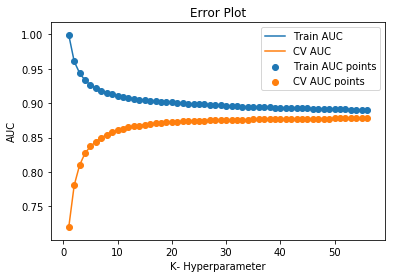

In [127]:
traintfw2v_auc=knn_w2v.cv_results_['mean_train_score']
cvtfw2v_auc=knn_w2v.cv_results_['mean_test_score']
print(traintfw2v_auc)
#print(k)
plt.plot(np.arange(1,57,1),traintfw2v_auc,label='Train AUC')
plt.plot(np.arange(1,57,1),cvtfw2v_auc,label='CV AUC')
plt.scatter(np.arange(1,57,1),traintfw2v_auc,label='Train AUC points')
plt.scatter(np.arange(1,57,1),cvtfw2v_auc,label='CV AUC points')
plt.legend()
plt.xlabel('K- Hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plot')


In [128]:
knn = KNeighborsClassifier(n_neighbors=k_w2v)
knn.fit(tfidf_w2v_train, Y_train)
y_traintfw2v_pred= knn.predict(tfidf_w2v_train)
y_testtfw2v_pred=knn.predict(tfid_w2v_test)
y_cvtfw2v_pred= knn.predict(tfid_w2v_cv)

In [129]:
traintfw2v_fpr,traintfw2v_tpr,thersholds=roc_curve(Y_train,y_traintfw2v_pred)
cvtfw2v_fpr,cvtfw2v_tpr,thersholds=roc_curve(Y_cv,y_cvtfw2v_pred)
testtfw2v_fpr,testtfw2v_tpr,thersholds=roc_curve(Y_test,y_testtfw2v_pred)

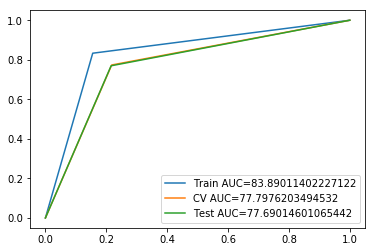

In [130]:
plt.plot(traintfw2v_fpr,traintfw2v_tpr,label="Train AUC=" +str(auc(traintfw2v_fpr,traintfw2v_tpr)*100))
plt.plot(cvtfw2v_fpr,cvtfw2v_tpr,label="CV AUC=" +str(auc(cvtfw2v_fpr,cvtfw2v_tpr)*100))
plt.plot(testtfw2v_fpr,testtfw2v_tpr,label="Test AUC=" +str(auc(testtfw2v_fpr,testtfw2v_tpr)*100))
plt.legend()

In [131]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Y_train,y_traintfw2v_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Y_cv,y_cvtfw2v_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Y_test,y_testtfw2v_pred)*100))

Accuracy on Train dataset: 83.89%
Accuracy on CV dataset: 77.80%
Accuracy on Test dataset: 77.70%


Text(33.0, 0.5, 'True Label')

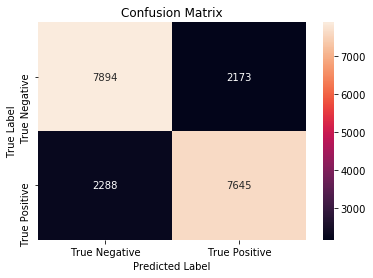

In [132]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Y_test,y_testtfw2v_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [212]:
print(classification_report(Y_test,y_testtfw2v_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     10067
           1       0.78      0.77      0.77      9933

   micro avg       0.78      0.78      0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 7645
    True Negative  : 7894
    False Positive : 2173 [Also know as type one error]
    False Negative : 2288 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (7645+7894)/20000 = 77.69 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 7)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (2173+2288)/20000 = 22.305 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 7)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 7645/ (7645+2173) = 77.86%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 7894/ (7894+2288) = 77.52%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 7645/ (7645+2288) = 76.96%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 7894/ (7894+2173) = 78.41%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.77
                    For -ve class = 0.78
OBSERVATION:
1. The model provides 78% accuracy on test data wheras it provides 84% accuracy on train data valid when K = 7.
2. From the confusion matrix, it can be deduced that out of 20K datapoints our KNN classfier predicts  9818 +ve and 10182 -ve class label but in reality 9933 +ve and 10067 -ve class labels.
3. We can conclude that model work good on unseen data as the accuracy is high provided K=7.

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [133]:
# Please write all the code with proper documentation

For KD tree implementationwe will use only 20K dataset.And split the data into test, Cv, train dataset. 

In [134]:
pos_1 = cleaned_data[cleaned_data["Score"]==1].sample(n=10000)
neg_1 = cleaned_data[cleaned_data["Score"]==0].sample(n=10000)
sample_20k = pd.concat([pos_1,neg_1])
sample_20k.shape

(20000, 12)

In [135]:
sample_20k['Time'] = pd.to_datetime(sample_20k['Time'], unit = 's')
sample_20k= sample_20k.sort_values(by='Time')

In [136]:
sample_20k.head()

index      Id   ProductId          UserId       ProfileName  \
429     417901  451923  B00004CXX9   ANIMV3SPDD8SH  Guy De Federicis   
250     346040  374342  B00004CI84  A10L8O1ZMUIMR2   G. Kleinschmidt   
994     333932  361319  B00005IX96   AGUF1WPEG4GSM        "lchang44"   
341038  420194  454404  B007JXVR76  A1ZXF1MOZZYAJC          "boycat"   
3482    347537  375927  B0000DBN1O  A1IU7S4HCK1XK0    Joanna Daneman   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
429                        1                      12      0 2001-06-11   
250                       61                      79      0 2002-12-27   
994                        5                       8      0 2003-06-12   
341038                     0                       6      1 2003-07-16   
3482                       7                       7      1 2003-12-29   

                                            Summary  \
429               CASPER IS THE GHOST WITH THE MOST   
250                          Great movie turned bad   
994                        Almost expired, Sept '03   
341038  Meow Mix is the best cat food in the WORLD!   
3482                                 Earl Grey, Hot   

                                                     Text  \
429     Michael Keaton brings no distinguishing charac...   
250     Just to let you know, this movie is one of my ...   
994     I returned this due to the very short/brief ex...   
341038  I love meow mix, my cats love it to. We all ea...   
3482    This is a strongly aromatic version of Earl Gr...   

                                         processed_review  
429     michael keaton brings no distinguishing charac...  
250     let know movie one personal favorite ghost mov...  
994     returned due short brief expiration date sept ...  
341038  love meow mix cats love eat togther cat mr kit...  
3482    strongly aromatic version earl grey scented ci...

In [137]:
X1 = sample_20k['processed_review']
Y1 = sample_20k['Score']

In [138]:
Xkd_train,Xkd_test,Ykd_train,Ykd_test= train_test_split(X1, Y1, test_size=0.4,random_state= 20)
Xkd_test,Xkd_cv,Ykd_test,Ykd_cv=train_test_split(Xkd_test,Ykd_test,test_size=0.5,random_state= 20)
print("The Shape of train data is :",Xkd_train.shape, Ykd_train.shape)
print("The Shape of CV data is :",Xkd_cv.shape, Ykd_cv.shape)
print("The Shape of test data is :",Xkd_test.shape, Ykd_test.shape)

The Shape of train data is : (12000,) (12000,)
The Shape of CV data is : (4000,) (4000,)
The Shape of test data is : (4000,) (4000,)


In [139]:
#We will make the model learn the vocab from train dataset. We will use countvectorizer to serve our purpose
vec= CountVectorizer()
vec.fit(Xkd_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [140]:
# Now we will apply the learned vocab to train,test,CV datawhich will produce an output in BOW format
bowkd_train=vec.fit_transform(Xkd_train)
bowkd_cv=vec.transform(Xkd_cv)
bowkd_test=vec.transform(Xkd_test)

In [141]:
print("After Vectorization")
print(bowkd_train.shape,Ykd_train.shape)
print(bowkd_cv.shape,Ykd_cv.shape)
print(bowkd_test.shape,Ykd_test.shape)

After Vectorization
(12000, 22955) (12000,)
(4000, 22955) (4000,)
(4000, 22955) (4000,)


In [142]:
bowkd_train
bowkd_cv=bowkd_cv.todense()
bowkd_test=bowkd_test.todense()

In [148]:
bowkd_train=bowkd_train.todense()

In [149]:
bowkd_train

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [145]:
from sklearn.metrics import roc_auc_score

In [150]:
# let us try for loop for KD tree implementation

train_auc=[]
cv_auc=[]
test_auc=[]
k = [1,5,11,13,17,25,27,33,36,41,53,57]
for i in k:
    knn=KNeighborsClassifier(n_neighbors = i, algorithm ='kd_tree',n_jobs = -1)
    knn.fit(bowkd_train,Ykd_train)
    y_train_pred = knn.predict(bowkd_train)
    y_cv_pred = knn.predict(bowkd_cv)
    y_test_pred = knn.predict(bowkd_test)
    train_auc.append(roc_auc_score(Ykd_train, y_train_pred))
    test_auc.append(roc_auc_score(Ykd_test, y_test_pred))
    cv_auc.append(roc_auc_score(Ykd_cv, y_cv_pred)) 
    

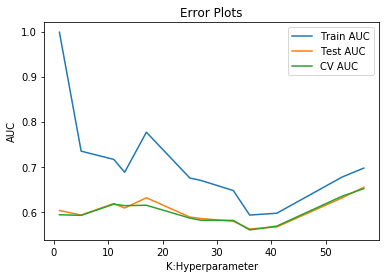

In [151]:
plt.plot(k, train_auc,label= 'Train AUC')
plt.plot(k, test_auc,label= 'Test AUC')
plt.plot(k,cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("K:Hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [152]:
print([k,train_auc])

[[1, 5, 11, 13, 17, 25, 27, 33, 36, 41, 53, 57], [0.9985034918523445, 0.734487971101176, 0.7162050937832883, 0.6876431882795806, 0.7765751446868989, 0.6748431185903123, 0.66961964570696, 0.6470522450622231, 0.5926232542821622, 0.5967348044450465, 0.6769452411463129, 0.6969306555113467]]


We will select the K value as 5 because of the accuracy of 73.44%

In [153]:
# let's test the accuracy of the selected K value on the CV and test data

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(bowkd_train, Ykd_train)
y_trainbow_pred= knn.predict(bowkd_train)
y_testbow_pred=knn.predict(bowkd_test)
y_cvbow_pred= knn.predict(bowkd_cv)

In [154]:
trainbow_fpr,trainbow_tpr,thersholds=roc_curve(Ykd_train,y_trainbow_pred)
cvbow_fpr,cvbow_tpr,thersholds=roc_curve(Ykd_cv,y_cvbow_pred)
testbow_fpr,testbow_tpr,thersholds=roc_curve(Ykd_test,y_testbow_pred)

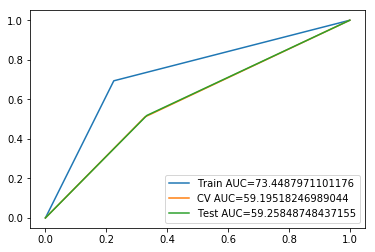

In [155]:
plt.plot(trainbow_fpr,trainbow_tpr,label="Train AUC=" +str(auc(trainbow_fpr,trainbow_tpr)*100))
plt.plot(cvbow_fpr,cvbow_tpr,label="CV AUC=" +str(auc(cvbow_fpr,cvbow_tpr)*100))
plt.plot(testbow_fpr,testbow_tpr,label="Test AUC=" +str(auc(testbow_fpr,testbow_tpr)*100))
plt.legend()

In [156]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Ykd_train,y_trainbow_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Ykd_cv,y_cvbow_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Ykd_test,y_testbow_pred)*100))

Accuracy on Train dataset: 73.46%
Accuracy on CV dataset: 59.17%
Accuracy on Test dataset: 59.23%


Text(33.0, 0.5, 'True Label')

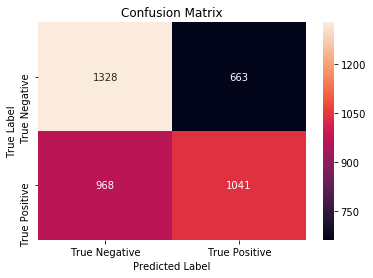

In [157]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Ykd_test,y_testbow_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [213]:
print(classification_report(Ykd_test,y_testbow_pred))

              precision    recall  f1-score   support

           0       0.58      0.67      0.62      1991
           1       0.61      0.52      0.56      2009

   micro avg       0.59      0.59      0.59      4000
   macro avg       0.59      0.59      0.59      4000
weighted avg       0.59      0.59      0.59      4000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 1041
    True Negative  : 1328
    False Positive : 663 [Also know as type one error]
    False Negative : 963 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (1041+1328)/4000 = 59.22 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 5)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (663+963)/4000 = 40.65 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 5)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 1041/ (1041+663) = 61.09%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 1328/ (1328+963) = 57.96%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 1041/ (1041+963) = 51.94%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 1328/ (1328+663) = 66.7%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.56
                    For -ve class = 0.62
OBSERVATION:
1. The model provides 60% accuracy on test data wheras it provides 73% accuracy on train data valid when K = 5.
2. From the confusion matrix, it can be deduced that out of 4K datapoints our KNN classfier predicts  1704 +ve and 2296 -ve class label but in reality 2004 +ve and 1991 -ve class labels.
3. We can conclude that model doesn't work good on unseen data as the generalization error is high provided K=5.

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [158]:
# Please write all the code with proper documentation

In [159]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=1000) # we are using bi grams
tf_idf_vect.fit(Xkd_train)
tf_train=tf_idf_vect.transform(Xkd_train)
tf_test=tf_idf_vect.transform(Xkd_test)
tf_cv=tf_idf_vect.transform(Xkd_cv)

In [160]:
print("After Vectorization")
print(tf_train.shape,Ykd_train.shape)
print(tf_cv.shape,Ykd_cv.shape)
print(tf_test.shape,Ykd_test.shape)

After Vectorization
(12000, 1000) (12000,)
(4000, 1000) (4000,)
(4000, 1000) (4000,)


In [161]:
tf_train

<12000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 290767 stored elements in Compressed Sparse Row format>

In [162]:
tf_train=tf_train.todense()


In [163]:
tf_train

matrix([[0.        , 0.        , 0.        , ..., 0.17796594, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.09573022],
        [0.        , 0.        , 0.        , ..., 0.        , 0.2120692 ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [164]:
tf_cv= tf_cv.todense()

In [165]:
tf_cv

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [166]:
tf_test=tf_test.todense()

In [167]:
# let us try for loop for KD tree implementation

train_auc=[]
cv_auc=[]
test_auc=[]
k = [1,5,11,13,17,25,27,33,36,41,53,57]
for i in k:
    knn=KNeighborsClassifier(n_neighbors = i, algorithm ='kd_tree',n_jobs = -1)
    knn.fit(tf_train,Ykd_train)
    y_train_pred = knn.predict(tf_train)
    y_cv_pred = knn.predict(tf_cv)
    y_test_pred = knn.predict(tf_test)
    train_auc.append(roc_auc_score(Ykd_train, y_train_pred))
    test_auc.append(roc_auc_score(Ykd_test, y_test_pred))
    cv_auc.append(roc_auc_score(Ykd_cv, y_cv_pred)) 
    

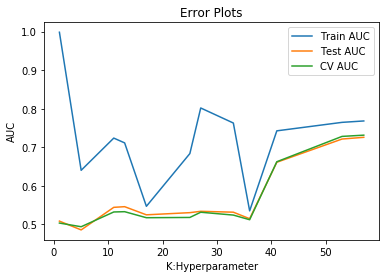

In [168]:
plt.plot(k, train_auc,label= 'Train AUC')
plt.plot(k, test_auc,label= 'Test AUC')
plt.plot(k,cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("K:Hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [169]:
print(k,train_auc)

[1, 5, 11, 13, 17, 25, 27, 33, 36, 41, 53, 57] [0.9984203525108082, 0.6403340140407431, 0.7238754133216947, 0.7114176510516558, 0.5469296166168016, 0.6837190280258193, 0.8019745885283153, 0.7629613483451186, 0.5351273579156154, 0.7426908213166938, 0.7646849688403858, 0.7683093496842371]


In [170]:
# let's test the accuracy of the selected K value on the CV and test data

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tf_train, Ykd_train)
y_traintf_pred= knn.predict(tf_train)
y_testtf_pred=knn.predict(tf_test)
y_cvtf_pred= knn.predict(tf_cv)

In [171]:
traintf_fpr,traintf_tpr,thersholds=roc_curve(Ykd_train,y_traintf_pred)
cvtf_fpr,cvtf_tpr,thersholds=roc_curve(Ykd_cv,y_cvtf_pred)
testtf_fpr,testtf_tpr,thersholds=roc_curve(Ykd_test,y_testtf_pred)

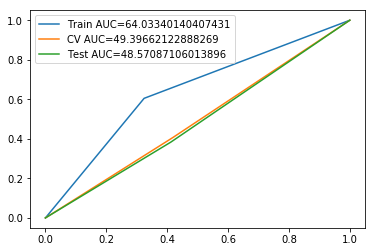

In [172]:
plt.plot(traintf_fpr,traintf_tpr,label="Train AUC=" +str(auc(traintf_fpr,traintf_tpr)*100))
plt.plot(cvtf_fpr,cvtf_tpr,label="CV AUC=" +str(auc(cvtf_fpr,cvtf_tpr)*100))
plt.plot(testtf_fpr,testtf_tpr,label="Test AUC=" +str(auc(testtf_fpr,testtf_tpr)*100))
plt.legend()

In [173]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Ykd_train,y_traintf_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Ykd_cv,y_cvtf_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Ykd_test,y_testtf_pred)*100))

Accuracy on Train dataset: 64.04%
Accuracy on CV dataset: 49.38%
Accuracy on Test dataset: 48.52%


Text(33.0, 0.5, 'True Label')

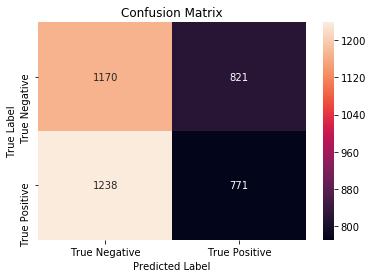

In [174]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Ykd_test,y_testtf_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [214]:
print(classification_report(Ykd_test,y_testtf_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      1991
           1       0.70      0.66      0.68      2009

   micro avg       0.69      0.69      0.69      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.69      0.69      0.69      4000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 771
    True Negative  : 1170
    False Positive : 821 [Also know as type one error]
    False Negative : 1238 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (771+1170)/4000 = 48.52 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 5)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (821+1238)/4000 = 51.47 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 5)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 771/ (771+821) = 48.42%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 1170/ (1170+1238) = 48.58%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 771/ (771+1238) = 38.37%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 1170/ (1170+821) = 58.76%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.68
                    For -ve class = 0.69
OBSERVATION:
1. The model provides 49% accuracy on test data wheras it provides 64% accuracy on train data valid when K = 5.
2. From the confusion matrix, it can be deduced that out of 4K datapoints our KNN classfier predicts  1592 +ve and 2408 -ve class label but in reality 2004 +ve and 1991 -ve class labels.
3. We can conclude that model doesn't work good on unseen data as the generalization error is high provided K=5.

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [175]:
# Please write all the code with proper documentation

In [176]:
# Train your own Word2Vec model using your own text corpus
i=0
sentancekd_train=[]
for sentance in Xkd_train:
    sentancekd_train.append(sentance.split())

In [177]:
# to train the W2V model on the provided list of sentences
w2v_model=Word2Vec(sentancekd_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7119
sample words  ['got', 'boxes', 'cereal', 'yesterday', 'sugar', 'scale', 'frosted', 'flakes', 'cardboard', 'would', 'give', 'removed', 'dried', 'strawberries', 'not', 'sweet', 'overall', 'think', 'nutrition', 'level', 'excellent', 'caloric', 'content', 'combined', 'whole', 'grain', 'contents', 'holds', 'hours', 'without', 'ratio', 'non', 'soluble', 'fiber', 'distinct', 'flavor', 'get', 'boring', 'mixed', 'yogurt', 'whatever', 'favorite', 'mix', 'tasteful', 'lightly', 'crispy', 'well', 'milk', 'keeper', 'glad']


In [178]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectorskd_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentancekd_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectorskd_train.append(sent_vec)
print(len(vectorskd_train))
print(len(vectorskd_train[0]))


 44%|█████████████████████████████████▋                                          | 5324/12000 [00:07<00:10, 634.66it/s]


 92%|████████████████████████████████████████████████████████████████████▋      | 10981/12000 [00:14<00:01, 704.90it/s]


100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:16<00:00, 749.34it/s]

12000
50


In [179]:
# Converting the CV data text
i=0
sentancekd_cv=[]
for sentance in Xkd_cv:
    sentancekd_cv.append(sentance.split())

In [180]:
# we will convert the CV data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectorskd_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentancekd_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectorskd_cv.append(sent_vec)
print(len(vectorskd_cv))
print(len(vectorskd_cv[0]))


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 754.62it/s]

4000
50


In [181]:
# Converting the test data text
i=0
sentancekd_test=[]
for sentance in Xkd_test:
    sentancekd_test.append(sentance.split())

In [182]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectorskd_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentancekd_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectorskd_test.append(sent_vec)
print(len(vectorskd_test))
print(len(vectorskd_test[0]))


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 782.97it/s]

4000
50


In [183]:
# let us try for loop for KD tree implementation

train_auc=[]
cv_auc=[]
test_auc=[]
k = [1,5,11,13,17,25,27,33,36,41,53,57]
for i in k:
    knn=KNeighborsClassifier(n_neighbors = i, algorithm ='kd_tree',n_jobs = -1)
    knn.fit(vectorskd_train,Ykd_train)
    y_train_pred = knn.predict(vectorskd_train)
    y_cv_pred = knn.predict(vectorskd_cv)
    y_test_pred = knn.predict(vectorskd_test)
    train_auc.append(roc_auc_score(Ykd_train, y_train_pred))
    test_auc.append(roc_auc_score(Ykd_test, y_test_pred))
    cv_auc.append(roc_auc_score(Ykd_cv, y_cv_pred)) 
    

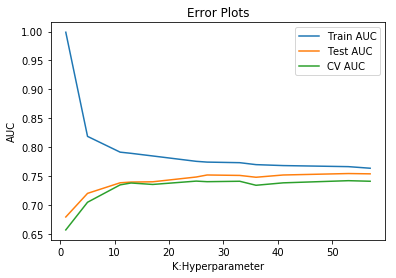

In [184]:
plt.plot(k, train_auc,label= 'Train AUC')
plt.plot(k, test_auc,label= 'Test AUC')
plt.plot(k,cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("K:Hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [185]:
print(k,train_auc)

[1, 5, 11, 13, 17, 25, 27, 33, 36, 41, 53, 57] [0.998747076511861, 0.8188602637947695, 0.7916036987312487, 0.7896013544962633, 0.7850181906545934, 0.7757613347006, 0.7744252718709246, 0.7734248775354444, 0.7700464146971467, 0.7684229058580431, 0.7665810069410377, 0.763837408670336]


In [186]:
# let's test the accuracy of the selected K value on the CV and test data

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(vectorskd_train, Ykd_train)
y_traina2w_pred= knn.predict(vectorskd_train)
y_testa2w_pred=knn.predict(vectorskd_test)
y_cva2w_pred= knn.predict(vectorskd_cv)

In [187]:
traina2w_fpr,traina2w_tpr,thersholds=roc_curve(Ykd_train,y_traina2w_pred)
cva2w_fpr,cva2w_tpr,thersholds=roc_curve(Ykd_cv,y_cva2w_pred)
testa2w_fpr,testa2w_tpr,thersholds=roc_curve(Ykd_test,y_testa2w_pred)

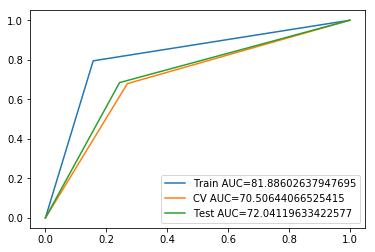

In [188]:
plt.plot(traina2w_fpr,traina2w_tpr,label="Train AUC=" +str(auc(traina2w_fpr,traina2w_tpr)*100))
plt.plot(cva2w_fpr,cva2w_tpr,label="CV AUC=" +str(auc(cva2w_fpr,cva2w_tpr)*100))
plt.plot(testa2w_fpr,testa2w_tpr,label="Test AUC=" +str(auc(testa2w_fpr,testa2w_tpr)*100))
plt.legend()

In [189]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Ykd_train,y_traina2w_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Ykd_cv,y_cva2w_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Ykd_test,y_testa2w_pred)*100))

Accuracy on Train dataset: 81.89%
Accuracy on CV dataset: 70.50%
Accuracy on Test dataset: 72.02%


Text(33.0, 0.5, 'True Label')

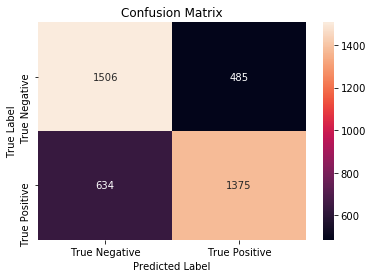

In [190]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Ykd_test,y_testa2w_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [215]:
print(classification_report(Ykd_test,y_testa2w_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1991
           1       0.74      0.68      0.71      2009

   micro avg       0.72      0.72      0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 1375
    True Negative  : 1506
    False Positive : 485 [Also know as type one error]
    False Negative : 634 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (1375+1506)/4000 = 72.02 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 5)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (485+634)/4000 = 27.97 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 5)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 1375/ (1375+485) = 73.92%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 1506/ (1506+634) = 70.37%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 1375/ (1375+634) = 68.44%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 1506/ (1506+485) = 75.64%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.71
                    For -ve class = 0.73
OBSERVATION:
1. The model provides 73% accuracy on test data wheras it provides 81% accuracy on train data valid when K = 5.
2. From the confusion matrix, it can be deduced that out of 4K datapoints our KNN classfier predicts  1860 +ve and 2140 -ve class label but in reality 2004 +ve and 1991 -ve class labels.
3. We can conclude that model work good on unseen data as accuracy on unseen data is high provided K=5.

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [191]:
# Please write all the code with proper documentation

In [192]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(Xkd_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [193]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentancekd_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


  7%|█████▋                                                                       | 880/12000 [00:07<01:43, 107.10it/s]


 15%|███████████▌                                                                 | 1796/12000 [00:16<02:15, 75.20it/s]


 22%|████████████████▉                                                            | 2647/12000 [00:24<01:55, 80.85it/s]


 29%|██████████████████████                                                      | 3489/12000 [00:32<01:15, 113.43it/s]


 36%|███████████████████████████▎                                                | 4311/12000 [00:40<00:58, 130.51it/s]


 43%|█████████████████████████████████▏                                           | 5166/12000 [00:48<01:13, 93.02it/s]


 50%|██████████████████████████████████████▋                                      | 6036/12000 [00:56<01:11, 83.92it/s]


 58%|████████████████████████████████████████████▍                                | 6924/12000 [01:04<00:53, 95.74it/s]


 65%|██████████████████████████████████████████████████▏                          | 7822/12000 [01:12<00:42, 98.41it/s]


 73%|███████████████████████████████████████████████████████▉                     | 8727/12000 [01:21<00:37, 86.57it/s]


 80%|████████████████████████████████████████████████████████████▋               | 9585/12000 [01:29<00:21, 111.31it/s]


 87%|█████████████████████████████████████████████████████████████████▎         | 10446/12000 [01:37<00:14, 107.38it/s]


 95%|██████████████████████████████████████████████████████████████████████▉    | 11345/12000 [01:46<00:05, 110.42it/s]


100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:52<00:00, 107.01it/s]

In [194]:
tfidf_w2v_train = np.array(tfidf_sent_vectors)

In [195]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentancekd_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1


 22%|█████████████████                                                              | 867/4000 [00:07<00:35, 87.17it/s]


 43%|█████████████████████████████████▊                                            | 1737/4000 [00:15<00:23, 94.97it/s]


 66%|██████████████████████████████████████████████████▉                          | 2648/4000 [00:24<00:12, 112.36it/s]


 89%|████████████████████████████████████████████████████████████████████▏        | 3545/4000 [00:32<00:04, 105.18it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:36<00:00, 110.89it/s]

In [196]:
tfidf_w2v_cv = np.array(tfidf_sent_vectors_cv)

In [200]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentancekd_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


 19%|██████████████▉                                                                | 754/4000 [00:08<00:37, 86.46it/s]


 40%|██████████████████████████████▊                                               | 1580/4000 [00:16<00:27, 87.16it/s]


 60%|██████████████████████████████████████████████▌                               | 2390/4000 [00:24<00:23, 68.11it/s]


 80%|█████████████████████████████████████████████████████████████▊               | 3209/4000 [00:32<00:07, 108.60it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:40<00:00, 113.01it/s]

In [201]:
tfidf_w2v_test = np.array(tfidf_sent_vectors_test)

In [202]:
# let us try for loop for KD tree implementation

train_auc=[]
cv_auc=[]
test_auc=[]
k = [1,5,11,13,17,25,27,33,36,41,53,57]
for i in k:
    knn=KNeighborsClassifier(n_neighbors = i, algorithm ='kd_tree',n_jobs = -1)
    knn.fit(tfidf_w2v_train,Ykd_train)
    y_train_pred = knn.predict(tfidf_w2v_train)
    y_cv_pred = knn.predict(tfidf_w2v_cv)
    y_test_pred = knn.predict(tfidf_w2v_test)
    train_auc.append(roc_auc_score(Ykd_train, y_train_pred))
    test_auc.append(roc_auc_score(Ykd_test, y_test_pred))
    cv_auc.append(roc_auc_score(Ykd_cv, y_cv_pred)) 
    

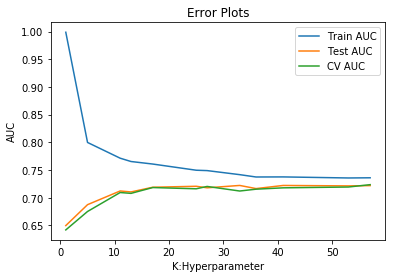

In [203]:
plt.plot(k, train_auc,label= 'Train AUC')
plt.plot(k, test_auc,label= 'Test AUC')
plt.plot(k,cv_auc,label='CV AUC')
plt.legend()
plt.xlabel("K:Hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [204]:
# let's test the accuracy of the selected K value on the CV and test data

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfidf_w2v_train, Ykd_train)
y_traintf_pred= knn.predict(tfidf_w2v_train)
y_testtf_pred=knn.predict(tfidf_w2v_test)
y_cvtf_pred= knn.predict(tfidf_w2v_cv)

In [205]:
traintf_fpr,traintf_tpr,thersholds=roc_curve(Ykd_train,y_traintf_pred)
cvtf_fpr,cvtf_tpr,thersholds=roc_curve(Ykd_cv,y_cvtf_pred)
testtf_fpr,testtf_tpr,thersholds=roc_curve(Ykd_test,y_testtf_pred)

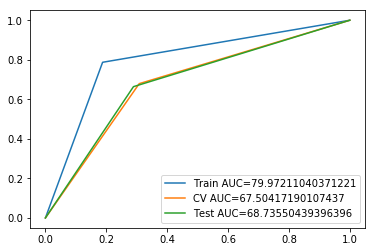

In [206]:
plt.plot(traintf_fpr,traintf_tpr,label="Train AUC=" +str(auc(traintf_fpr,traintf_tpr)*100))
plt.plot(cvtf_fpr,cva2w_tpr,label="CV AUC=" +str(auc(cvtf_fpr,cvtf_tpr)*100))
plt.plot(testtf_fpr,testtf_tpr,label="Test AUC=" +str(auc(testtf_fpr,testtf_tpr)*100))
plt.legend()

In [207]:
print("Accuracy on Train dataset: %0.2f%%" %(accuracy_score(Ykd_train,y_traintf_pred)*100))
print("Accuracy on CV dataset: %0.2f%%" %(accuracy_score(Ykd_cv,y_cvtf_pred)*100))
print("Accuracy on Test dataset: %0.2f%%" %(accuracy_score(Ykd_test,y_testtf_pred)*100))

Accuracy on Train dataset: 79.97%
Accuracy on CV dataset: 67.50%
Accuracy on Test dataset: 68.73%


Text(33.0, 0.5, 'True Label')

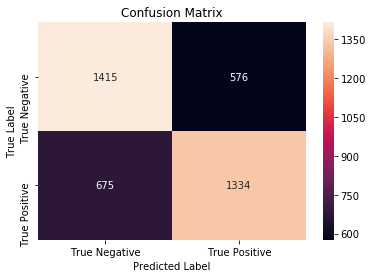

In [208]:
class_label = ["True Negative", "True Positive"]
cm=pd.DataFrame(confusion_matrix(Ykd_test,y_testtf_pred),index=class_label,columns=class_label)
sns.heatmap(cm,annot=True,fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [216]:
print(classification_report(Ykd_test,y_testtf_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      1991
           1       0.70      0.66      0.68      2009

   micro avg       0.69      0.69      0.69      4000
   macro avg       0.69      0.69      0.69      4000
weighted avg       0.69      0.69      0.69      4000



DETAILED UNDERSTANDING OF CONFUSION MATRIX:
1. Let us describe the results using confusion matrix,a metric used to describe the performance of classifier.
    True positive  : 1334
    True Negative  : 1415
    False Positive : 576 [Also know as type one error]
    False Negative : 675 [Also know as type two error]
    
2. To know how often our model predicts CORRECT class label, we will calculate the accuracy metric using ((TP+TN)/Total Data Points(DP))
    (1334+1415)/4000 = 68.75 %
    NOTE: This is the accuracy on test points provided selected K( Hyperparameter to be 5)
    
3. To know how often our model predicts WRONG class label(also know as Misclassificaton Error Rate(MER), we will calculate the accuracy metric using ((FP+FN)/Total Data Points(DP))
    (576+675)/4000 = 31.27 %
    NOTE: This is the misclassification on test points provided selected K( Hyperparameter to be 5)

4. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Positive Class:  TP/ Predicted(True positive + False positive)
                       = 1334/ (1334+576) = 69.84%
5. From the classification report,  we have parameter Precision ( Provides how accurate the predicted class belongs to exact same class)
   For Negative Class:  TN/ Predicted(True negative + False negative)
                       = 1415/ (1415+675) = 67.70%
6. True positive Rate/ Recall/Sensitivity is when the class label is actual positive and how often the model predicts it to be positive.
    For Positive Class: True Positive/ Actual Positive (TP+FN)
                        = 1334/ (1334+675) = 66.40%
7. True Negative Rate/Specificity  is when the class label is actual negative and how often the model predicts it to be negative.
    For Negative Class: True Negative/ Actual Negative (TN+FP)
                        = 1415/ (1415+576) = 71.06%
8. F1 Score is the measure of model's accuracy combining recall and precision. A model is said to be perfect if F1 score is 1 and its complete failure if its 0. We need to tune the hyperparameter to get the optimised F1 score.
                    F1 = 2 * ((Precision*Recall)/ (Precision+Recall))
                    For +ve Class = 0.68
                    For -ve class = 0.69
OBSERVATION:
1. The model provides 69% accuracy on test data wheras it provides 80% accuracy on train data valid when K = 5.
2. From the confusion matrix, it can be deduced that out of 4K datapoints our KNN classfier predicts  1910 +ve and 2090 -ve class label but in reality 2004 +ve and 1991 -ve class labels.
3. We can conclude that model work good on unseen data as accuracy on unseen data is high provided K=5.

# [6] Conclusions

In [209]:
# Please compare all your models using Prettytable library

In [218]:
from prettytable import PrettyTable
    
tab = PrettyTable()

In [219]:
tab.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

tab.add_row(["BOW", "BRUTE", 12, 0.62])
tab.add_row(["TFIDF", "BRUTE", 4, 0.51])
tab.add_row(["W2V", "BRUTE", 5, 0.79])
tab.add_row(["TFIDFW2V", "BRUTE", 7, 0.77])
tab.add_row(["BOW", "KDTREE", 5, 0.60])
tab.add_row(["TFIDF", "KDTREE", 5, 0.51])
tab.add_row(["W2V", "KDTREE", 5, 0.72])
tab.add_row(["TFIDFW2V", "KDTREE", 5, 0.69])

In [220]:
print(tab)

+------------+--------+----------------+------+
| Vectorizer | Model  | Hyperparameter | AUC  |
+------------+--------+----------------+------+
|    BOW     | BRUTE  |       12       | 0.62 |
|   TFIDF    | BRUTE  |       4        | 0.51 |
|    W2V     | BRUTE  |       5        | 0.79 |
|  TFIDFW2V  | BRUTE  |       7        | 0.77 |
|    BOW     | KDTREE |       5        | 0.6  |
|   TFIDF    | KDTREE |       5        | 0.51 |
|    W2V     | KDTREE |       5        | 0.72 |
|  TFIDFW2V  | KDTREE |       5        | 0.69 |
+------------+--------+----------------+------+


#References
1. https://stackoverflow.com/questions/28161356/sort-pandas-dataframe-by-date
2.https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a